# (3) Project 4 Modelling Part 1

---
I have scraped, cleaned, and explored job listings data from au.indeed.com. I will now make a model to predict salary. I will be doing a simple classification model to predict high salary vs low salary. The EDA revealed that the mean and median annual salary are extremely close and the mean is not significantly affected by positive outliers. Therefore, I will split my data based on the mean annual salary of \$109,902.91. Anything greater than the mean will be high salary, anything less than or equal to the mean will be classed as low salary.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('clean_jobs.csv')      # Read in the clean data.

In [3]:
df.head()

,location,title,company,salary,salary_type,summary,description
0,sydney,data scientist python r,correlate resources,110000.0,year,work within a team of industry leading data sc...,our client is an industry pioneering customer ...
1,sydney,data scientists x 2,alloc8 recruitment solutions pty ltd,150000.0,year,the need for 2 data scientist is paramount and...,the company alloc8 have been fortunate enoug...
2,sydney,data analyst perm role sydney,infopeople,92500.0,year,i am looking for a data analyst with at least ...,i am looking for a data analyst with at least ...
3,sydney,senior data scientist leadership position,morgan mckinley,170000.0,year,the time has come to step up and be counted as...,calling all senior data scientists the ti...
4,sydney,junior data scientist,correlate resources,75000.0,year,as a junior data scientist the responsibilitie...,our client is an industry pioneering customer ...


---
I will create a new target column to record whether the listed salary is above or below the mean annual salary.

---

In [4]:
df['sal_above_mean'] = np.nan    # Create column for salary above mean, values are NaN.
df.head()

,location,title,company,salary,salary_type,summary,description,sal_above_mean
0,sydney,data scientist python r,correlate resources,110000.0,year,work within a team of industry leading data sc...,our client is an industry pioneering customer ...,NaN
1,sydney,data scientists x 2,alloc8 recruitment solutions pty ltd,150000.0,year,the need for 2 data scientist is paramount and...,the company alloc8 have been fortunate enoug...,NaN
2,sydney,data analyst perm role sydney,infopeople,92500.0,year,i am looking for a data analyst with at least ...,i am looking for a data analyst with at least ...,NaN
3,sydney,senior data scientist leadership position,morgan mckinley,170000.0,year,the time has come to step up and be counted as...,calling all senior data scientists the ti...,NaN
4,sydney,junior data scientist,correlate resources,75000.0,year,as a junior data scientist the responsibilitie...,our client is an industry pioneering customer ...,NaN


In [5]:
df.ix[df["salary"] > df["salary"].mean(), "sal_above_mean"] = 1     # Impute 1 where listed salaries are above mean.
df.ix[df["salary"] <= df["salary"].mean(), "sal_above_mean"] = 0    # Impute 0 where listed salaries are below mean.
# Jobs without a listed salary will remain as NaN.

/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [6]:
df.head()

,location,title,company,salary,salary_type,summary,description,sal_above_mean
0,sydney,data scientist python r,correlate resources,110000.0,year,work within a team of industry leading data sc...,our client is an industry pioneering customer ...,1.0
1,sydney,data scientists x 2,alloc8 recruitment solutions pty ltd,150000.0,year,the need for 2 data scientist is paramount and...,the company alloc8 have been fortunate enoug...,1.0
2,sydney,data analyst perm role sydney,infopeople,92500.0,year,i am looking for a data analyst with at least ...,i am looking for a data analyst with at least ...,0.0
3,sydney,senior data scientist leadership position,morgan mckinley,170000.0,year,the time has come to step up and be counted as...,calling all senior data scientists the ti...,1.0
4,sydney,junior data scientist,correlate resources,75000.0,year,as a junior data scientist the responsibilitie...,our client is an industry pioneering customer ...,0.0


In [7]:
df.tail()

,location,title,company,salary,salary_type,summary,description,sal_above_mean
4367,adelaide,sales agronomist regional,farmers edge,NaN,NaN,from seed selection to yield data analytics f...,farmers edge is a global leader in decision ag...,NaN
4368,adelaide,animation supervisor,rising sun pictures rsp,NaN,NaN,please review our privacy policy for informati...,reporting directly to cg and vfx supervisors ...,NaN
4369,adelaide,vfx supervisor,rising sun pictures rsp,NaN,NaN,please review our privacy policy for informati...,the vfx supervisor is required to supervise m...,NaN
4370,adelaide,management accountant,egm partners,NaN,NaN,work collaboratively with the financial accoun...,we are resruiting a senior management accounta...,NaN
4371,adelaide,cg supervisor,rising sun pictures rsp,NaN,NaN,please review our privacy policy for informati...,the cg supervisor will supervise monitor dir...,NaN


---
Now that I have a target, I need predictors. I have scaped job summary and job description, which are text. I will need to use natural language processing (NLP) to analyse the data and determine if certain words appear more often in summaries/descriptions of high salary jobs than those of low salary jobs. I will then use those words to create binary features for the model. I will also do this for job title and company.

---

## NLP

---
I can only use the job listings with salaries for the modelling. I will then use the model to predict high or low salary for jobs that do not have a listed salary.

---

In [8]:
salary = df[df.salary.notnull()]    # Create dataframe of jobs that have a listed salary. 

In [9]:
salary.shape   # 838 jobs with a salary.

(838, 8)

---
Before I initialise the NLP count vectorizer, I need to create target (y) and feature (X) dataframes.

---

In [10]:
X_sal = salary.iloc[::, 0:7]  # All columns except sal_above_mean. 
X_sal.shape

(838, 7)

In [11]:
y_sal = salary.iloc[::, -1]   # sal_above_mean column only.
y_sal.shape

(838,)

---
Now I can create an NLP count vectorizer. I will use the count vectorizer to count ngrams of 1 to 3 words that appear in the records. I can then count the number of times each ngram appears in high salary jobs and low salary jobs. I can then use the count to create a high salary : low salary count ratio for the ngrams which will give an indication of which words appear more (and are therefore more important) in the high vs low salary records.

---

In [12]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 3), min_df=0.025, analyzer='word')
# Remove stop words such as 'the' and 'and'. Ngram range of 1 to 3 words. Only use words that appear in at least 2.5% of the dataframe.

### Job Title

---
First I will look at job title.

---

In [13]:
cvec.fit(X_sal['title'])   # Fit the count vectorizer to the X dataframe.

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.025,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [14]:
title_words = pd.DataFrame(cvec.transform(X_sal['title']).todense(), columns=cvec.get_feature_names())
# Create dataframe to show if an ngram appears in a record.

In [15]:
title_words.shape

(838, 25)

In [16]:
title_words = pd.concat([title_words, y_sal], axis=1)  # Concatonate sal_above_mean.
title_words.head()

,analyst,analytics,business,business analyst,commercial,consultant,contract,data,data analyst,data scientist,...,lead,manager,research,scientist,senior,senior business,senior business analyst,sydney,technical,sal_above_mean
0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0.0
3,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,1,0,0,0,0,1.0
4,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0.0


---
I have now used the cout vectorizer to produce ngrams that appear in the job title data. Having concatonated sal_above_mean to the dataframe, I can slice the data to perform a count of each ngram for high salary data and low salary data.

---

In [17]:
title_count_below = title_words[title_words['sal_above_mean'] == 0].sum()    # Word count for low salary.
print ('Word count for 0 (salary below mean):\n')
print (title_count_below.sort_values(ascending = False))

print ('\n')

title_count_above = title_words[title_words['sal_above_mean'] == 1].sum()     # Word count for high salary.
print ('Word count for 1 (salary above mean):\n')
print (title_count_above.sort_values(ascending = False))

Word count for 0 (salary below mean):

analyst                    273.0
business                    89.0
data                        83.0
business analyst            67.0
data analyst                46.0
senior                      39.0
junior                      21.0
consultant                  21.0
financial                   16.0
finance                     15.0
commercial                  15.0
analytics                   14.0
manager                     14.0
digital                     14.0
developer                   14.0
research                    13.0
scientist                   12.0
contract                    12.0
technical                   11.0
engineer                    10.0
data scientist               9.0
sydney                       9.0
senior business              6.0
senior business analyst      6.0
lead                         3.0
sal_above_mean               0.0
dtype: float64


Word count for 1 (salary above mean):

sal_above_mean             423.0
analyst       

---
Now I can create a new dataframe with both high salary and low salary word counts. Then I can create a new column to find the ratio for each ngram.

---

In [18]:
title_count_compare = pd.DataFrame([title_count_below, title_count_above]).T    # Dataframe for word counts of high and low salary job titles.
title_count_compare["ratio"] = title_count_compare[1]/title_count_compare[0]   # Create another column for ratio: high salary word count / low salary word count.
title_count_compare.ratio.sort_values(ascending=False)

sal_above_mean                  inf
lead                       6.666667
senior business            4.333333
senior business analyst    3.666667
senior                     3.025641
engineer                   2.700000
data scientist             2.444444
scientist                  2.000000
manager                    1.785714
business analyst           1.611940
data                       1.518072
business                   1.449438
sydney                     1.444444
analytics                  1.214286
developer                  1.214286
technical                  1.181818
finance                    1.133333
financial                  1.062500
contract                   1.000000
analyst                    0.941392
commercial                 0.733333
digital                    0.714286
research                   0.615385
consultant                 0.523810
data analyst               0.521739
junior                     0.000000
Name: ratio, dtype: float64

---
I have now produced a ratio of ngrams that appear in high salary job titles compared to low salary job titles. The higher the number, the more often that word appears in a high salary job. The lower the number, the more often it appears in low salary jobs. I will choose a number of ngrams from the top as predictors of high salary jobs and a number of ngrams from the bottom as predictors of low salary jobs. I will later use these ngrams to create features for the model.

---

Ngrams with a ratio above 2 I will classify as good job titles (lead, senior business, senior business analyst, senior, engineer, data scientist, scientist).
<br>Ngrams with a ratio below 0.75 I will clasify as bad job titles (junior, data analyst, consultant, research, digital, commerical).
<br><br>
These words indicate that senior job titles and scientist job titles are indicative of high salary. Words such as junior, digital, and commercial appear more often in low salary jobs.

---

I will now repeat this process for company, job summary, and job description.

---

### Company

In [19]:
cvec.fit(X_sal['company'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.025,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [20]:
company_words = pd.DataFrame(cvec.transform(X_sal['company']).todense(), columns=cvec.get_feature_names())

In [21]:
company_words.shape

(838, 18)

In [22]:
company_words = pd.concat([company_words, y_sal], axis=1)
company_words.head()

,australia,consulting,group,half,half australia,hays,hudson,michael,michael page,page,pty,recruitment,robert,robert half,robert half australia,services,solutions,university,sal_above_mean
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [23]:
company_count_below = company_words[company_words['sal_above_mean'] == 0].sum()
print ('Word count for 0 (salary below mean):\n')
print (company_count_below.sort_values(ascending = False))

print ('\n')

company_count_above = company_words[company_words['sal_above_mean'] == 1].sum()
print ('Word count for 1 (salary above mean):\n')
print (company_count_above.sort_values(ascending = False))

Word count for 0 (salary below mean):

recruitment              47.0
page                     44.0
michael                  39.0
michael page             39.0
hays                     31.0
australia                29.0
university               24.0
pty                      22.0
group                    19.0
robert                   15.0
robert half              15.0
robert half australia    15.0
half australia           15.0
half                     15.0
services                 10.0
solutions                 9.0
consulting                8.0
hudson                    5.0
sal_above_mean            0.0
dtype: float64


Word count for 1 (salary above mean):

sal_above_mean           423.0
recruitment               60.0
group                     34.0
hudson                    30.0
michael                   23.0
michael page              23.0
page                      23.0
hays                      20.0
australia                 20.0
pty                       17.0
robert                   

In [24]:
company_count_compare = pd.DataFrame([company_count_below, company_count_above]).T
company_count_compare["ratio"] = company_count_compare[1]/company_count_compare[0]
company_count_compare.ratio.sort_values(ascending=False)

sal_above_mean                inf
hudson                   6.000000
consulting               1.875000
group                    1.789474
solutions                1.666667
recruitment              1.276596
services                 1.200000
half australia           1.000000
robert half australia    1.000000
robert half              1.000000
robert                   1.000000
half                     1.000000
pty                      0.772727
australia                0.689655
hays                     0.645161
michael                  0.589744
michael page             0.589744
page                     0.522727
university               0.416667
Name: ratio, dtype: float64

---
I will only be picking words that could act as an important predictor of high vs low salaries. Therefore, I will not be using a lot of the ngrams, such as 'michael page' or 'hudson', that refer to specific companies. I am after general words in a company's title that might be able to indicate whether that company is more or less likely to pay a high salary.

---
Ngrams above 1.5 are good job titles (consulting, group, solutions).
<br>Ngrams below 0.75 are bad job titles (university, australia).
<br><br>
This suggests that consulting companies and companies with 'solutions' in the title are more likely to pay a high salary than universities.

---

### Summary

In [25]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 3), min_df=0.05, analyzer='word')
# Summary has a lot more words than title and company, so use only words that appear in 5% of dataframe.
cvec.fit(X_sal['summary'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.05,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [26]:
summary_words = pd.DataFrame(cvec.transform(X_sal['summary']).todense(), columns=cvec.get_feature_names())

In [27]:
summary_words.shape

(838, 34)

In [28]:
summary_words = pd.concat([summary_words, y_sal], axis=1)
summary_words.head()

,ability,analysis,analyst,analysts,analytics,big,big data,business,business analyst,client,...,seeking,senior,skills,support,team,technical,work,working,years,sal_above_mean
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1.0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [29]:
summary_count_below = summary_words[summary_words['sal_above_mean'] == 0].sum()
print ('Word count for 0 (salary below mean):\n')
print (summary_count_below.sort_values(ascending = False))

print ('\n')

summary_count_above = summary_words[summary_words['sal_above_mean'] == 1].sum()
print ('Word count for 1 (salary above mean):\n')
print (summary_count_above.sort_values(ascending = False))

Word count for 0 (salary below mean):

data                354.0
business            286.0
analyst             197.0
experience           81.0
business analyst     68.0
analysis             68.0
role                 62.0
big                  57.0
team                 49.0
financial            47.0
working              40.0
client               40.0
data analyst         37.0
work                 36.0
senior               36.0
reporting            36.0
years                32.0
analytics            32.0
support              30.0
management           30.0
skills               29.0
looking              27.0
large                26.0
provide              25.0
seeking              25.0
opportunity          25.0
join                 22.0
ability              21.0
development          21.0
technical            21.0
big data             20.0
analysts             20.0
experienced          19.0
modelling            15.0
sal_above_mean        0.0
dtype: float64


Word count for 1 (salary above mea

In [30]:
summary_count_compare = pd.DataFrame([summary_count_below, summary_count_above]).T
summary_count_compare["ratio"] = summary_count_compare[1]/summary_count_compare[0]
summary_count_compare.ratio.sort_values(ascending=False)

sal_above_mean           inf
big data            2.150000
analysts            2.100000
modelling           2.000000
senior              1.611111
join                1.590909
business analyst    1.573529
experience          1.567901
technical           1.476190
team                1.367347
experienced         1.315789
data                1.305085
ability             1.285714
work                1.194444
big                 1.192982
management          1.133333
business            1.132867
development         1.095238
analyst             1.086294
provide             1.040000
analytics           1.031250
working             0.950000
client              0.950000
seeking             0.920000
looking             0.888889
reporting           0.861111
large               0.846154
opportunity         0.840000
analysis            0.808824
skills              0.793103
years               0.718750
support             0.700000
financial           0.680851
data analyst        0.675676
role          

---
I will only be using ngrams that have some meaning related to the job, so I would not pick words such as 'role' and 'working'.

---

Ngrams above 1.5 are good summaries (big data, analysts, modelling, senior, business analyst, experience).
<br>Ngrams below 0.7 are bad summaries (data analyst, financial, support).
<br><br>
The summary data suggests that roles that requiring big data, modelling, and experiance for senior roles or more likely to have a high salary.

---

### Description

In [31]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 3), min_df=0.05, max_df=0.75, analyzer='word')
# A lot of words in the description so only use words that appear in at least 5% and at most 75% of the description.
cvec.fit(X_sal['description'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=None, min_df=0.05,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [32]:
description_words = pd.DataFrame(cvec.transform(X_sal['description']).todense(), columns=cvec.get_feature_names())

In [33]:
description_words.shape

(838, 1359)

In [34]:
description_words = pd.concat([description_words, y_sal], axis=1)
description_words.head()

,00,000,000 00,02,03,07,10,10 days,10 days ago,100,...,writing,written,written communication,written verbal,written verbal communication,www,year,years,years experience,sal_above_mean
0,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,3,3,3,0,...,0,0,0,0,0,0,0,0,0,0.0


In [35]:
description_count_below = description_words[description_words['sal_above_mean'] == 0].sum()
print ('Word count for 0 (salary below mean):\n')
print (description_count_below.sort_values(ascending = False))

print ('\n')

description_count_above = description_words[description_words['sal_above_mean'] == 1].sum()
print ('Word count for 1 (salary above mean):\n')
print (description_count_above.sort_values(ascending = False))

Word count for 0 (salary below mean):

nsw                       1142.0
sydney                    1029.0
melbourne                  998.0
vic                        977.0
sydney nsw                 728.0
melbourne vic              727.0
work                       697.0
document                   677.0
new                        676.0
team                       673.0
recjoblink                 582.0
management                 558.0
days ago easily            542.0
var                        508.0
analysis                   486.0
ia                         472.0
working                    471.0
australia                  450.0
business analyst           447.0
support                    443.0
client                     434.0
recruitment                412.0
financial                  401.0
ability                    392.0
page                       390.0
hours                      389.0
function                   385.0
services                   380.0
senior                     379.0
mich

In [36]:
description_count_compare = pd.DataFrame([description_count_below, description_count_above]).T
description_count_compare["ratio"] = description_count_compare[1]/description_count_compare[0]
description_count_compare.ratio.sort_values(ascending=False)

sal_above_mean                inf
aws                      9.666667
migration                6.705882
architect                6.105263
submit application       5.714286
data engineer            4.928571
business process         4.368421
agile                    4.311111
deliverables             4.083333
business processes       4.055556
touch                    3.800000
architecture             3.652174
07                       3.500000
ago senior business      3.500000
define                   3.437500
acting                   3.272727
machine learning         3.233333
experience business      3.200000
models                   3.179487
machine                  3.129032
supply chain             3.119048
job senior               3.117647
driving                  3.117647
apply job senior         3.117647
nsw paxus                3.090909
paxus sydney nsw         3.090909
sydney nsw paxus         3.090909
nsw paxus australia      3.090909
paxus sydney             3.090909
business analy

---
Again, I will only be using description ngrams that have some meaning to the role.

---

---
Ngrams above 4 are good descriptions: (aws, migration, architect, data engineer, business process, agile, deliverables, business processes)
<br>Ngrams below 0.35 are bad descriptions (audit, administration, officer, accountant, customer service, assistant)
<br><br>The description data suggests that more technical skills such as data engineering, systems architecture, and aws as well as being more involved in the business processes of the company are more likely to be sought after for high salary jobs. The low salary jobs ask for more basic, less technical, skills such as administration and customer service.

---

## Features

---
I have now finished the NLP and can now use my chosen ngrams to create binary features for the model.

---

In [37]:
salary.head()

,location,title,company,salary,salary_type,summary,description,sal_above_mean
0,sydney,data scientist python r,correlate resources,110000.0,year,work within a team of industry leading data sc...,our client is an industry pioneering customer ...,1.0
1,sydney,data scientists x 2,alloc8 recruitment solutions pty ltd,150000.0,year,the need for 2 data scientist is paramount and...,the company alloc8 have been fortunate enoug...,1.0
2,sydney,data analyst perm role sydney,infopeople,92500.0,year,i am looking for a data analyst with at least ...,i am looking for a data analyst with at least ...,0.0
3,sydney,senior data scientist leadership position,morgan mckinley,170000.0,year,the time has come to step up and be counted as...,calling all senior data scientists the ti...,1.0
4,sydney,junior data scientist,correlate resources,75000.0,year,as a junior data scientist the responsibilitie...,our client is an industry pioneering customer ...,0.0


### Job Title

---
For job title, I will create two new columns/features. The column good_title will be a 1 if a job's title has one of the good title ngrams and 0 if not. Likewise, bad_title will be a 1 if a job's title has one of the bad title ngrams.

---

In [38]:
salary['good_title'] = 0     # New column for good title feature, value of 0.
salary.ix[(salary.title.str.contains('lead') |
           salary.title.str.contains('senior business') |
           salary.title.str.contains('senior business analyst') |
           salary.title.str.contains('senior') |
           salary.title.str.contains('engineer') |
           salary.title.str.contains('data scientist') |
           salary.title.str.contains('scientist')), 'good_title'] = 1      # Change value to 1 if the title contains any of these good title words.


salary['bad_title'] = 0           # Repeat for bad_title.
salary.ix[(salary.title.str.contains('junior') |
           salary.title.str.contains('data analyst') |
           salary.title.str.contains('consultant') |
           salary.title.str.contains('research') |
           salary.title.str.contains('digital') |
           salary.title.str.contains('commercial')), 'bad_title'] = 1
salary.head(10)

/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,location,title,company,salary,salary_type,summary,description,sal_above_mean,good_title,bad_title
0,sydney,data scientist python r,correlate resources,110000.0,year,work within a team of industry leading data sc...,our client is an industry pioneering customer ...,1.0,1,0
1,sydney,data scientists x 2,alloc8 recruitment solutions pty ltd,150000.0,year,the need for 2 data scientist is paramount and...,the company alloc8 have been fortunate enoug...,1.0,1,0
2,sydney,data analyst perm role sydney,infopeople,92500.0,year,i am looking for a data analyst with at least ...,i am looking for a data analyst with at least ...,0.0,0,1
3,sydney,senior data scientist leadership position,morgan mckinley,170000.0,year,the time has come to step up and be counted as...,calling all senior data scientists the ti...,1.0,1,0
4,sydney,junior data scientist,correlate resources,75000.0,year,as a junior data scientist the responsibilitie...,our client is an industry pioneering customer ...,0.0,1,1
5,sydney,scientist,science division,108792.0,year,data layers satellite imagery photography o...,scientist 00006173 job title scientist job...,0.0,1,0
6,sydney,event research analyst,destination nsw corporate services,93704.5,year,outline your experience in carrying out market...,event research analyst 0000650n ongoing fu...,0.0,0,1
7,sydney,big data engineer scala,onset group pty ltd,120000.0,year,collaboration with data scientists engagement...,here you'll get to work on cutting edge produc...,1.0,1,0
8,sydney,front end developer react angular data sta...,thedrivegroup,150000.0,year,we are looking for 3 front end web developers ...,front end developer react angular html cs...,1.0,0,0
9,sydney,senior data scientist,genesis it t pty ltd,170000.0,year,our client seeks an experienced data scientist...,our client seeks an experienced data scientist...,1.0,1,0


---
I now have my two new binary features for predicting high salaries vs low salaries. I will repeat this process for company, salary, and description. I will create two new features for each one. One for the ngrams that are strongly associated with high salary jobs and the other for ngrams that are associated with low salary jobs.

---

### Company

---
Create good_company and bad_company features.

---

In [39]:
salary['good_company'] = 0
salary.ix[(salary.company.str.contains('consulting') |
           salary.company.str.contains('group') |
           salary.company.str.contains('solutions')), 'good_company'] = 1


salary['bad_company'] = 0
salary.ix[(salary.company.str.contains('university') |
           salary.company.str.contains('australia')), 'bad_company'] = 1
salary.head(10)

/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,location,title,company,salary,salary_type,summary,description,sal_above_mean,good_title,bad_title,good_company,bad_company
0,sydney,data scientist python r,correlate resources,110000.0,year,work within a team of industry leading data sc...,our client is an industry pioneering customer ...,1.0,1,0,0,0
1,sydney,data scientists x 2,alloc8 recruitment solutions pty ltd,150000.0,year,the need for 2 data scientist is paramount and...,the company alloc8 have been fortunate enoug...,1.0,1,0,1,0
2,sydney,data analyst perm role sydney,infopeople,92500.0,year,i am looking for a data analyst with at least ...,i am looking for a data analyst with at least ...,0.0,0,1,0,0
3,sydney,senior data scientist leadership position,morgan mckinley,170000.0,year,the time has come to step up and be counted as...,calling all senior data scientists the ti...,1.0,1,0,0,0
4,sydney,junior data scientist,correlate resources,75000.0,year,as a junior data scientist the responsibilitie...,our client is an industry pioneering customer ...,0.0,1,1,0,0
5,sydney,scientist,science division,108792.0,year,data layers satellite imagery photography o...,scientist 00006173 job title scientist job...,0.0,1,0,0,0
6,sydney,event research analyst,destination nsw corporate services,93704.5,year,outline your experience in carrying out market...,event research analyst 0000650n ongoing fu...,0.0,0,1,0,0
7,sydney,big data engineer scala,onset group pty ltd,120000.0,year,collaboration with data scientists engagement...,here you'll get to work on cutting edge produc...,1.0,1,0,1,0
8,sydney,front end developer react angular data sta...,thedrivegroup,150000.0,year,we are looking for 3 front end web developers ...,front end developer react angular html cs...,1.0,0,0,1,0
9,sydney,senior data scientist,genesis it t pty ltd,170000.0,year,our client seeks an experienced data scientist...,our client seeks an experienced data scientist...,1.0,1,0,0,0


### Summary

---
Create good_summary and bad_summary features.

---

In [40]:
salary['good_summary'] = 0
salary.ix[(salary.title.str.contains('big data') |
           salary.title.str.contains('analysts') |
           salary.title.str.contains('modelling') |
           salary.title.str.contains('senior') |
           salary.title.str.contains('business analyst') |
           salary.title.str.contains('experience')), 'good_summary'] = 1


salary['bad_summary'] = 0
salary.ix[(salary.title.str.contains('data analyst') |
           salary.title.str.contains('financial') |
           salary.title.str.contains('support')), 'bad_summary'] = 1
salary.head(10)

/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,location,title,company,salary,salary_type,summary,description,sal_above_mean,good_title,bad_title,good_company,bad_company,good_summary,bad_summary
0,sydney,data scientist python r,correlate resources,110000.0,year,work within a team of industry leading data sc...,our client is an industry pioneering customer ...,1.0,1,0,0,0,0,0
1,sydney,data scientists x 2,alloc8 recruitment solutions pty ltd,150000.0,year,the need for 2 data scientist is paramount and...,the company alloc8 have been fortunate enoug...,1.0,1,0,1,0,0,0
2,sydney,data analyst perm role sydney,infopeople,92500.0,year,i am looking for a data analyst with at least ...,i am looking for a data analyst with at least ...,0.0,0,1,0,0,0,1
3,sydney,senior data scientist leadership position,morgan mckinley,170000.0,year,the time has come to step up and be counted as...,calling all senior data scientists the ti...,1.0,1,0,0,0,1,0
4,sydney,junior data scientist,correlate resources,75000.0,year,as a junior data scientist the responsibilitie...,our client is an industry pioneering customer ...,0.0,1,1,0,0,0,0
5,sydney,scientist,science division,108792.0,year,data layers satellite imagery photography o...,scientist 00006173 job title scientist job...,0.0,1,0,0,0,0,0
6,sydney,event research analyst,destination nsw corporate services,93704.5,year,outline your experience in carrying out market...,event research analyst 0000650n ongoing fu...,0.0,0,1,0,0,0,0
7,sydney,big data engineer scala,onset group pty ltd,120000.0,year,collaboration with data scientists engagement...,here you'll get to work on cutting edge produc...,1.0,1,0,1,0,1,0
8,sydney,front end developer react angular data sta...,thedrivegroup,150000.0,year,we are looking for 3 front end web developers ...,front end developer react angular html cs...,1.0,0,0,1,0,0,0
9,sydney,senior data scientist,genesis it t pty ltd,170000.0,year,our client seeks an experienced data scientist...,our client seeks an experienced data scientist...,1.0,1,0,0,0,1,0


### Description

---
Create good_description and bad_description features.

---

In [41]:
salary['good_description'] = 0
salary.ix[(salary.title.str.contains('aws') |
           salary.title.str.contains('migration') |
           salary.title.str.contains('architect') |
           salary.title.str.contains('data engineer') |
           salary.title.str.contains('business process') |
           salary.title.str.contains('agile') |
           salary.title.str.contains('deliverables') |
           salary.title.str.contains('business processes')), 'good_description'] = 1


salary['bad_description'] = 0
salary.ix[(salary.title.str.contains('audit') |
           salary.title.str.contains('administration') |
           salary.title.str.contains('officer') |
           salary.title.str.contains('accountant') |
           salary.title.str.contains('customer service') |
           salary.title.str.contains('assistant')), 'bad_description'] = 1
salary.head(10)

/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,location,title,company,salary,salary_type,summary,description,sal_above_mean,good_title,bad_title,good_company,bad_company,good_summary,bad_summary,good_description,bad_description
0,sydney,data scientist python r,correlate resources,110000.0,year,work within a team of industry leading data sc...,our client is an industry pioneering customer ...,1.0,1,0,0,0,0,0,0,0
1,sydney,data scientists x 2,alloc8 recruitment solutions pty ltd,150000.0,year,the need for 2 data scientist is paramount and...,the company alloc8 have been fortunate enoug...,1.0,1,0,1,0,0,0,0,0
2,sydney,data analyst perm role sydney,infopeople,92500.0,year,i am looking for a data analyst with at least ...,i am looking for a data analyst with at least ...,0.0,0,1,0,0,0,1,0,0
3,sydney,senior data scientist leadership position,morgan mckinley,170000.0,year,the time has come to step up and be counted as...,calling all senior data scientists the ti...,1.0,1,0,0,0,1,0,0,0
4,sydney,junior data scientist,correlate resources,75000.0,year,as a junior data scientist the responsibilitie...,our client is an industry pioneering customer ...,0.0,1,1,0,0,0,0,0,0
5,sydney,scientist,science division,108792.0,year,data layers satellite imagery photography o...,scientist 00006173 job title scientist job...,0.0,1,0,0,0,0,0,0,0
6,sydney,event research analyst,destination nsw corporate services,93704.5,year,outline your experience in carrying out market...,event research analyst 0000650n ongoing fu...,0.0,0,1,0,0,0,0,0,0
7,sydney,big data engineer scala,onset group pty ltd,120000.0,year,collaboration with data scientists engagement...,here you'll get to work on cutting edge produc...,1.0,1,0,1,0,1,0,1,0
8,sydney,front end developer react angular data sta...,thedrivegroup,150000.0,year,we are looking for 3 front end web developers ...,front end developer react angular html cs...,1.0,0,0,1,0,0,0,0,0
9,sydney,senior data scientist,genesis it t pty ltd,170000.0,year,our client seeks an experienced data scientist...,our client seeks an experienced data scientist...,1.0,1,0,0,0,1,0,0,0


### Other Columns

---
Now that I have created new features from the NLP ngrams, I can look at the other variables. I will convert location to dummy variables, with each city being a binary feature. I will then remove location, title, company, salary, salary_type, summary, and description to leave me with a completely numeric (and completely binary) dataset. Because I will later be using my model to predict the salaries for jobs without a listed salary, I cannot use salary_type in my model. Even though it is likely to be a good predictor of salary, the jobs without salaries will not have a salary_type that I can feed into the model. Therefore, it must be left out.

---

In [42]:
salary.head()

,location,title,company,salary,salary_type,summary,description,sal_above_mean,good_title,bad_title,good_company,bad_company,good_summary,bad_summary,good_description,bad_description
0,sydney,data scientist python r,correlate resources,110000.0,year,work within a team of industry leading data sc...,our client is an industry pioneering customer ...,1.0,1,0,0,0,0,0,0,0
1,sydney,data scientists x 2,alloc8 recruitment solutions pty ltd,150000.0,year,the need for 2 data scientist is paramount and...,the company alloc8 have been fortunate enoug...,1.0,1,0,1,0,0,0,0,0
2,sydney,data analyst perm role sydney,infopeople,92500.0,year,i am looking for a data analyst with at least ...,i am looking for a data analyst with at least ...,0.0,0,1,0,0,0,1,0,0
3,sydney,senior data scientist leadership position,morgan mckinley,170000.0,year,the time has come to step up and be counted as...,calling all senior data scientists the ti...,1.0,1,0,0,0,1,0,0,0
4,sydney,junior data scientist,correlate resources,75000.0,year,as a junior data scientist the responsibilitie...,our client is an industry pioneering customer ...,0.0,1,1,0,0,0,0,0,0


In [43]:
cities = pd.get_dummies(salary.location)    # Create dummy variables from location column then concatonate them to main dataframe.
salary = pd.concat([salary, cities], axis=1)

In [44]:
salary.head()

,location,title,company,salary,salary_type,summary,description,sal_above_mean,good_title,bad_title,...,bad_company,good_summary,bad_summary,good_description,bad_description,adelaide,brisbane,melbourne,perth,sydney
0,sydney,data scientist python r,correlate resources,110000.0,year,work within a team of industry leading data sc...,our client is an industry pioneering customer ...,1.0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,sydney,data scientists x 2,alloc8 recruitment solutions pty ltd,150000.0,year,the need for 2 data scientist is paramount and...,the company alloc8 have been fortunate enoug...,1.0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,sydney,data analyst perm role sydney,infopeople,92500.0,year,i am looking for a data analyst with at least ...,i am looking for a data analyst with at least ...,0.0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,sydney,senior data scientist leadership position,morgan mckinley,170000.0,year,the time has come to step up and be counted as...,calling all senior data scientists the ti...,1.0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,sydney,junior data scientist,correlate resources,75000.0,year,as a junior data scientist the responsibilitie...,our client is an industry pioneering customer ...,0.0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [45]:
salary.drop(['location', 'title', 'company', 'salary', 'salary_type', 'summary', 'description'], axis=1, inplace=True)
# Drop all non-binary columns.

In [46]:
salary.head()

,sal_above_mean,good_title,bad_title,good_company,bad_company,good_summary,bad_summary,good_description,bad_description,adelaide,brisbane,melbourne,perth,sydney
0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,1,0,1,0,0,0,0,0,0,0,0,0,1
2,0.0,0,1,0,0,0,1,0,0,0,0,0,0,1
3,1.0,1,0,0,0,1,0,0,0,0,0,0,0,1
4,0.0,1,1,0,0,0,0,0,0,0,0,0,0,1


In [47]:
salary.shape

(838, 14)

---
I am now left with a completely binary column that has 17 predictor features and the sal_above_mean target variable.

---

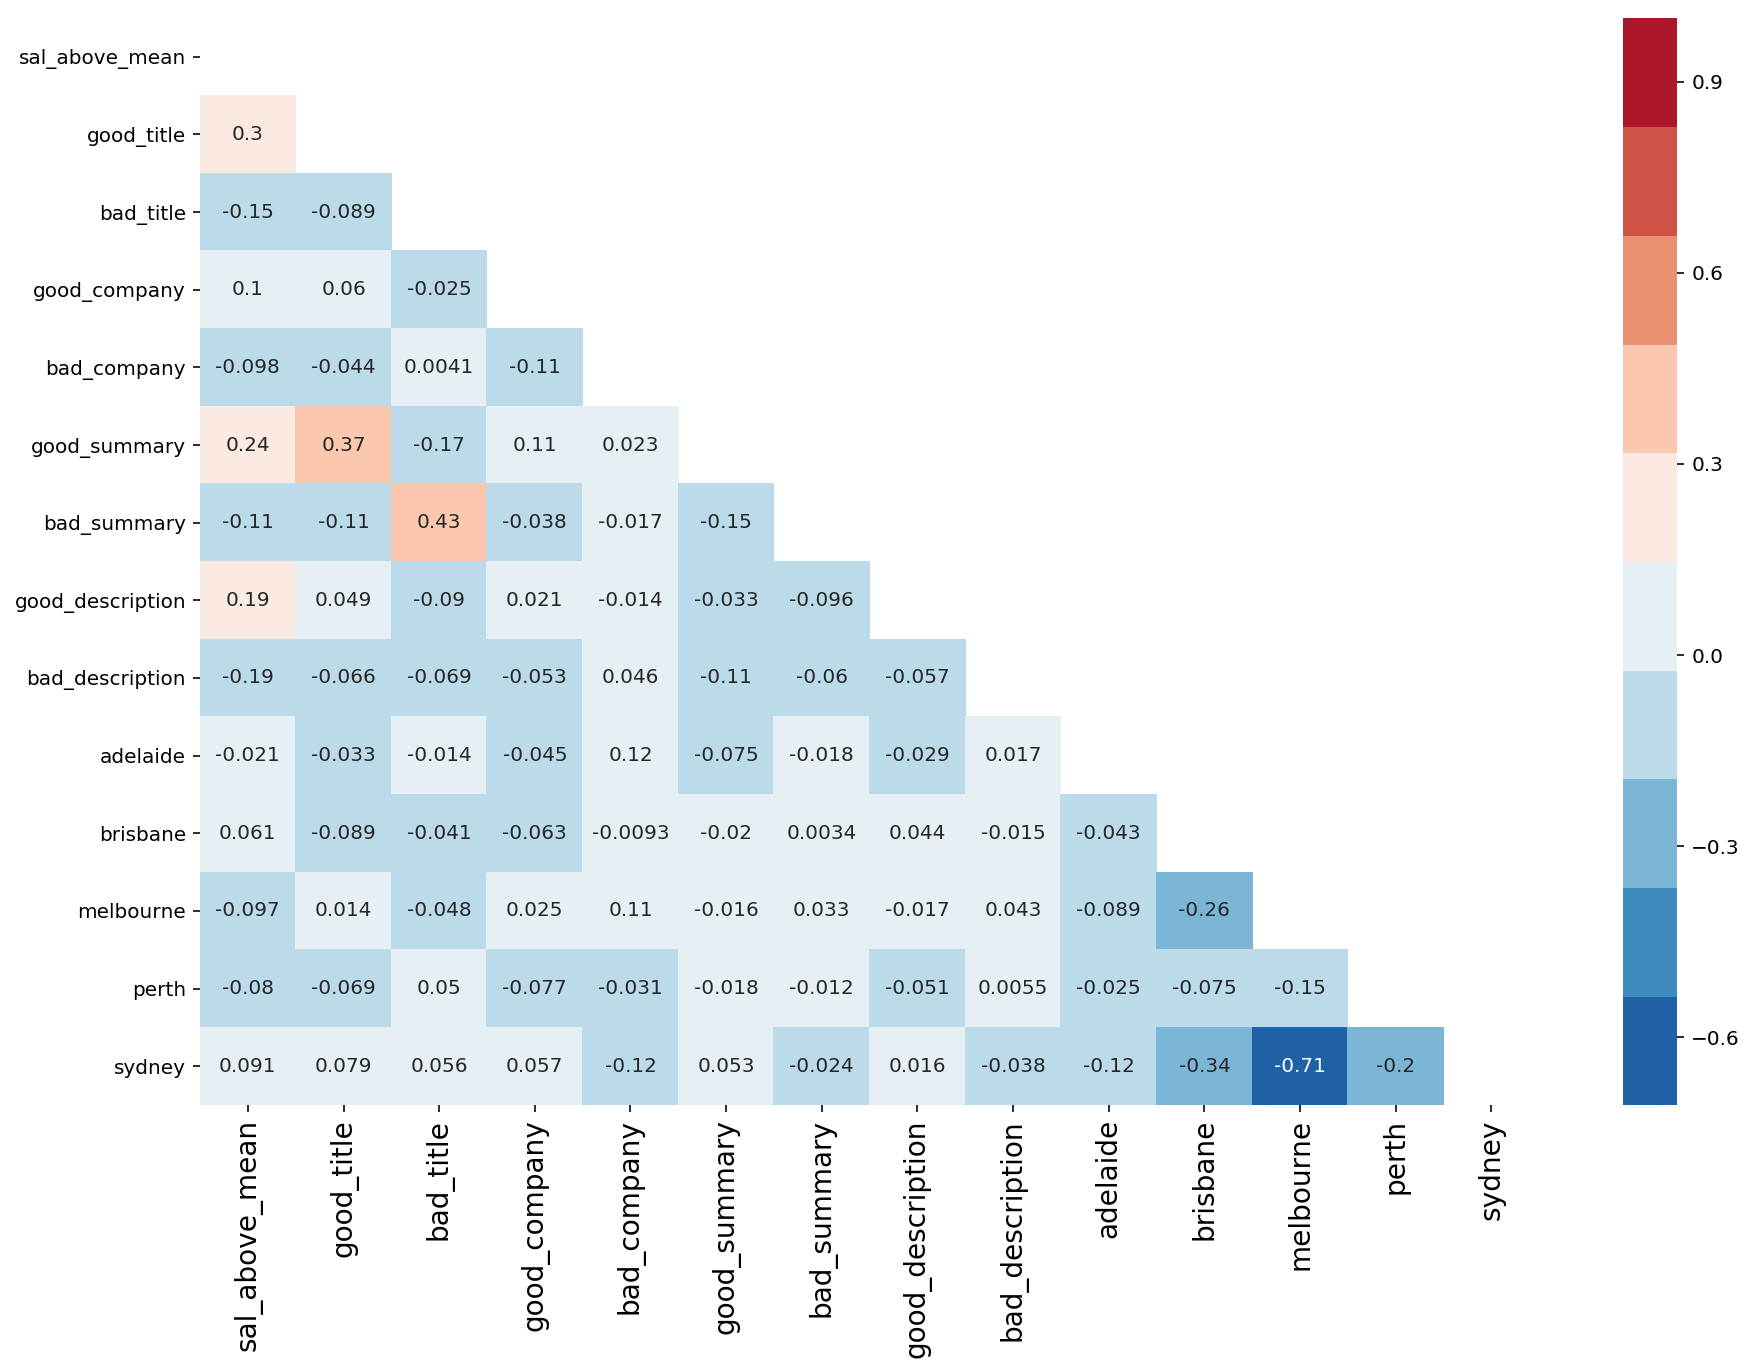

In [48]:
# Create heatmap to shoe correlation between features.
corr = salary.corr()
fig, ax = plt.subplots(figsize=(15,10))
mask = np.zeros_like(corr, dtype=np.bool)    # Create a mask to stop upper right portion of heatmap from showing.
mask[np.triu_indices_from(mask)] = True
cmap = (sns.color_palette("RdBu_r", 10))     # Diverging colour palette.
ax = sns.heatmap(corr, mask=mask, ax=ax, cmap=cmap, annot=True)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
plt.show()

---
I created a heatmap to check correlation between the feature as I do not want collinearity in my model. Sydney and Melbourne have strong negative correlation and year has moderately strong negative correlation with day and hour. However, I will only remove features that have a correlation of at least 0.75 (or -0.75), of which there are none.

---

## Logistic Regression

---
Now that I have my features, I can create a model to predict high or low salary. I will be using logistic regression as it is a good algorithm for predicting binary variables.

---

In [49]:
X_sal = salary.iloc[::, 1::]     # Create predictor dataframe X.
X_sal.shape

(838, 13)

In [50]:
y_sal = salary.iloc[::, 0]      # Create target y.
y_sal.shape

(838,)

---
I will perform a train/test split on my data with a ratio of 75:25. I will stratify the split on y_sal to ensure that there are similar proportions of the target in both training and testing data.

---

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_sal, y_sal, test_size=0.25, stratify=y_sal, random_state=34)
# Train/test split, stratify on y_sal, choose a random state so that I am able re-run the algorithm with the same train/test split.

In [52]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (628, 13)
y_train shape: (628,)
X_test shape: (210, 13)
y_test shape: (210,)


### Training

---
Now that I have split my data into training and testing subsets, I can train the model.

---

In [53]:
X = X_train.values    # Create X and y variables.
y = y_train.values    

In [54]:
X_test = X_test.values    # Same for test data.
y_test = y_test.values

In [55]:
# Check baseline accuracy. Can use 1 - mean for binary variables.
baseline_acc = 1 - y_sal.mean()
baseline_acc

0.49522673031026254

---
I classified high vs low salaries based on the mean annual salary, which was very close to the median. Because of this, I am getting a baseline accuracy of around 50%.

---

In [56]:
# Create logistic regression model and fit to X and y.
logreg = LogisticRegression()
model = logreg.fit(X, y)

In [57]:
# Check model score.
model.score(X,y)

0.695859872611465

---
The accuracy score of the model is significantly higher than the baseline.

---

In [58]:
# Check cross validated score on training data.
cv_scores = cross_val_score(logreg, X, y, cv=5)   # 5 folds.
print ("Cross-validated scores:", cv_scores)
print ('Mean:', cv_scores.mean())

Cross-validated scores: [0.66929134 0.71428571 0.664      0.696      0.664     ]
Mean: 0.6815154105736784


---
Performing cross validation on the training data reveals how the model performs on different sections of the data. The scores are fairly consistent and have a mean that is very close to the accuracy score from the training data.

---

I can now check the confusion matrix and classification report to check for false positives/negatives.

---

In [59]:
predictions = model.predict(X)

In [60]:
print (confusion_matrix(y, predictions))  # True (-ve),  False (+ve)
                                          # False (-ve), True (+ve)
print('\n')    
print(classification_report(y, predictions, target_names=['below_mean', 'above_mean']))    

[[225  86]
 [105 212]]


             precision    recall  f1-score   support

 below_mean       0.68      0.72      0.70       311
 above_mean       0.71      0.67      0.69       317

avg / total       0.70      0.70      0.70       628



---
The classification report reveals that my model has more false negatives than false positives. This means that it is incorrectly predicting low salary more than it is incorrectly predicting high salary.

---

---
I have trained my data and now I can test it.

---

### Testing

In [61]:
# Model's predictions for the test data.
model.predict(X_test)   

array([0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
       1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 1.])

In [62]:
model.score(X_test, y_test)

0.7238095238095238

---
The model performs well on the test data and the score is only slightly worse than the training score.

---

In [63]:
# Check cross validated score on test data.
cv_scores = cross_val_score(logreg, X_test, y_test, cv=5)  # Again 5 folds.
print ("Cross-validated scores:", cv_scores)
print ('Mean:', cv_scores.mean())

Cross-validated scores: [0.6744186  0.61904762 0.73809524 0.66666667 0.6097561 ]
Mean: 0.6615968452043324


---
Although the model does not perform quite as well on the testing data when exposed to different folds, the range of the scores is just over 10 which is not too high.

---

In [64]:
# Probability of a record in test data being a 0 or 1.
model.predict_proba(X_test)

array([[0.91109758, 0.08890242],
       [0.16649123, 0.83350877],
       [0.53037957, 0.46962043],
       [0.49881118, 0.50118882],
       [0.53537823, 0.46462177],
       [0.53537823, 0.46462177],
       [0.53537823, 0.46462177],
       [0.42184467, 0.57815533],
       [0.28426818, 0.71573182],
       [0.53537823, 0.46462177],
       [0.53537823, 0.46462177],
       [0.53537823, 0.46462177],
       [0.3850712 , 0.6149288 ],
       [0.53537823, 0.46462177],
       [0.53537823, 0.46462177],
       [0.94573805, 0.05426195],
       [0.16790925, 0.83209075],
       [0.60750584, 0.39249416],
       [0.28297437, 0.71702563],
       [0.53537823, 0.46462177],
       [0.20240171, 0.79759829],
       [0.53537823, 0.46462177],
       [0.47815956, 0.52184044],
       [0.36607454, 0.63392546],
       [0.42069348, 0.57930652],
       [0.53537823, 0.46462177],
       [0.17977749, 0.82022251],
       [0.42069348, 0.57930652],
       [0.53537823, 0.46462177],
       [0.25804039, 0.74195961],
       [0.

In [65]:
print (confusion_matrix(y_test, model.predict(X_test)))  # True (-ve),  False (+ve)
                                                         # False (-ve), True (+ve)
print ('\n')
print(classification_report(y_test, model.predict(X_test), target_names=['below_mean', 'above_mean']))    

[[81 23]
 [35 71]]


             precision    recall  f1-score   support

 below_mean       0.70      0.78      0.74       104
 above_mean       0.76      0.67      0.71       106

avg / total       0.73      0.72      0.72       210



---
As with the training data, the model predicts more false negatives than false positives on the test data. The default of the model is to predict the class that has more than 50% probabilty. However, at the expense of accuracy, it is possible to choose a different probability threshold to predict a certain class. This will make the model more likely to predict false negatives or false positives.

---

The bonus question of Project requires tuning the model so that it is more sensitive to predicting false negatives. The business motive behind this is that if you were to predict high vs low salary for a job that someone is applying for, that person would prefer to be incorrectly predicted a low salary but end up with a high salary than told they would get a high salary only to then receive a low salary. I am happy with the accuracy score of my model, and the fact that it produces more false negatives than false positives, so I will leave my model as it is.

---

In [66]:
# Check coefficients and intercepts.
print('Logreg intercept:', model.intercept_)
print('Logreg coefs:', model.coef_)

Logreg intercept: [-0.31713039]
Logreg coefs: [[ 1.05142343 -0.59446825  0.14650504 -0.53103175  0.46167702  0.01018377
   1.79480054 -1.74376548 -0.28566536  0.40454778 -0.2662148  -0.34517862
   0.17538061]]


In [67]:
# Create dataframe to look at coefficients of each feature.
logreg_coefs = pd.DataFrame({'feature':X_train.columns,
                            'coef':model.coef_.flatten(),     # Use .flatten() to convert coefs array into a 1 dimensional array.
                            'abs_coef':np.abs(model.coef_.flatten())})

logreg_coefs.sort_values('abs_coef', inplace=True, ascending=False)
logreg_coefs

,abs_coef,coef,feature
6,1.794801,1.794801,good_description
7,1.743765,-1.743765,bad_description
0,1.051423,1.051423,good_title
1,0.594468,-0.594468,bad_title
3,0.531032,-0.531032,bad_company
4,0.461677,0.461677,good_summary
9,0.404548,0.404548,brisbane
11,0.345179,-0.345179,perth
8,0.285665,-0.285665,adelaide
10,0.266215,-0.266215,melbourne


---
Checking the coefficients of the model, it is shown that the features that are the strongest predictors are good_description, bad_description, and good_title. All have a magnitude above 1. good_description is a good predictor of high salary jobs and low_description is a good predictor of low salary jobs. Therefore, descriptions that include technical roles such as data engineering and architecture, software like aws, and involvement in the business processes are more likely to predict high salary. Descriptions that include less technical roles such as administration, customer service, and assistant are more likely to predict low salary.

The cities were not as good as predictors although, unsurprisingly, Brisbane had the highest value. This was expected because it had the highest mean salary and the largest proportion of jobs with daily and hourly salary type listed. Therefore, it is better able to predict high salary than the other cities.

---

## Predicting Null Salaries

---
Now that I have made a model to predict whether a job will have a high salary or low salary, I can use it to predict whether the jobs that did not list a salary have a high or low salary.

---

In [68]:
# Create a dataframe with jobs that do not have a listed salary.
null_salary = df[df.salary.isnull()]
null_salary.head(10)

,location,title,company,salary,salary_type,summary,description,sal_above_mean
838,sydney,junior data analyst scientist,international institute of data analytics,NaN,NaN,in data science and big data analytics the id...,the international institute of data analytic...,NaN
839,sydney,senior data scientist,amazon com,NaN,NaN,a senior data scientist will our data scient...,excited by using massive amounts of data to de...,NaN
840,sydney,research scientist,amazon com,NaN,NaN,data drives the development of new process da...,business today operates at the pinnacle of the...,NaN
841,sydney,data scientist sydney,c3 iot,NaN,NaN,in this capacity you will participate in the ...,in this capacity you will participate in the ...,NaN
842,sydney,data scientist,buildingiq,NaN,NaN,we are looking for a data scientist to be a pa...,job description location – sydney australia...,NaN
843,sydney,data scientist,fortune select,NaN,NaN,experience using and maintaining aws environme...,location sydney job type permanent skills ...,NaN
844,sydney,data scientist,black swallow boutique,NaN,NaN,we are looking for an experienced data scienti...,we are looking for an experienced data scienti...,NaN
845,sydney,data analytics,kpmg,NaN,NaN,using data science techniques and machine lear...,be a key part of our growth innovation strat...,NaN
846,sydney,data scientist,sai global,NaN,NaN,proficiency with data visualisation and data s...,at sai global we make intelligent risk possib...,NaN
847,sydney,data scientist google technical services,google,NaN,NaN,engage various stakeholders assess data readi...,google technical services professional servic...,NaN


---
Now that I have a dataframe containing the jobs without a salary, I will need to create the same features as before to put into the model.

---

In [69]:
predict_data = null_salary.iloc[::, 0:7]

#### Job Title

In [70]:
predict_data['good_title'] = 0
predict_data.ix[(predict_data.title.str.contains('lead') |
                 predict_data.title.str.contains('senior business') |
                 predict_data.title.str.contains('senior business analyst') |
                 predict_data.title.str.contains('senior') |
                 predict_data.title.str.contains('engineer') |
                 predict_data.title.str.contains('data scientist') |
                 predict_data.title.str.contains('scientist')), 'good_title'] = 1


predict_data['bad_title'] = 0
predict_data.ix[(predict_data.title.str.contains('junior') |
                 predict_data.title.str.contains('data analyst') |
                 predict_data.title.str.contains('consultant') |
                 predict_data.title.str.contains('research') |
                 predict_data.title.str.contains('digital') |
                 predict_data.title.str.contains('commercial')), 'bad_title'] = 1
predict_data.head(10)

/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,location,title,company,salary,salary_type,summary,description,good_title,bad_title
838,sydney,junior data analyst scientist,international institute of data analytics,NaN,NaN,in data science and big data analytics the id...,the international institute of data analytic...,1,1
839,sydney,senior data scientist,amazon com,NaN,NaN,a senior data scientist will our data scient...,excited by using massive amounts of data to de...,1,0
840,sydney,research scientist,amazon com,NaN,NaN,data drives the development of new process da...,business today operates at the pinnacle of the...,1,1
841,sydney,data scientist sydney,c3 iot,NaN,NaN,in this capacity you will participate in the ...,in this capacity you will participate in the ...,1,0
842,sydney,data scientist,buildingiq,NaN,NaN,we are looking for a data scientist to be a pa...,job description location – sydney australia...,1,0
843,sydney,data scientist,fortune select,NaN,NaN,experience using and maintaining aws environme...,location sydney job type permanent skills ...,1,0
844,sydney,data scientist,black swallow boutique,NaN,NaN,we are looking for an experienced data scienti...,we are looking for an experienced data scienti...,1,0
845,sydney,data analytics,kpmg,NaN,NaN,using data science techniques and machine lear...,be a key part of our growth innovation strat...,0,0
846,sydney,data scientist,sai global,NaN,NaN,proficiency with data visualisation and data s...,at sai global we make intelligent risk possib...,1,0
847,sydney,data scientist google technical services,google,NaN,NaN,engage various stakeholders assess data readi...,google technical services professional servic...,1,0


#### Company

In [71]:
predict_data['good_company'] = 0
predict_data.ix[(predict_data.company.str.contains('consulting') |
                 predict_data.company.str.contains('group') |
                 predict_data.company.str.contains('solutions')), 'good_company'] = 1


predict_data['bad_company'] = 0
predict_data.ix[(predict_data.company.str.contains('university') |
                 predict_data.company.str.contains('australia')), 'bad_company'] = 1
predict_data.head(10)

,location,title,company,salary,salary_type,summary,description,good_title,bad_title,good_company,bad_company
838,sydney,junior data analyst scientist,international institute of data analytics,NaN,NaN,in data science and big data analytics the id...,the international institute of data analytic...,1,1,0,0
839,sydney,senior data scientist,amazon com,NaN,NaN,a senior data scientist will our data scient...,excited by using massive amounts of data to de...,1,0,0,0
840,sydney,research scientist,amazon com,NaN,NaN,data drives the development of new process da...,business today operates at the pinnacle of the...,1,1,0,0
841,sydney,data scientist sydney,c3 iot,NaN,NaN,in this capacity you will participate in the ...,in this capacity you will participate in the ...,1,0,0,0
842,sydney,data scientist,buildingiq,NaN,NaN,we are looking for a data scientist to be a pa...,job description location – sydney australia...,1,0,0,0
843,sydney,data scientist,fortune select,NaN,NaN,experience using and maintaining aws environme...,location sydney job type permanent skills ...,1,0,0,0
844,sydney,data scientist,black swallow boutique,NaN,NaN,we are looking for an experienced data scienti...,we are looking for an experienced data scienti...,1,0,0,0
845,sydney,data analytics,kpmg,NaN,NaN,using data science techniques and machine lear...,be a key part of our growth innovation strat...,0,0,0,0
846,sydney,data scientist,sai global,NaN,NaN,proficiency with data visualisation and data s...,at sai global we make intelligent risk possib...,1,0,0,0
847,sydney,data scientist google technical services,google,NaN,NaN,engage various stakeholders assess data readi...,google technical services professional servic...,1,0,0,0


#### Summary

In [72]:
predict_data['good_summary'] = 0
predict_data.ix[(predict_data.title.str.contains('big data') |
                 predict_data.title.str.contains('analysts') |
                 predict_data.title.str.contains('modelling') |
                 predict_data.title.str.contains('senior') |
                 predict_data.title.str.contains('business analyst') |
                 predict_data.title.str.contains('experience')), 'good_summary'] = 1


predict_data['bad_summary'] = 0
predict_data.ix[(predict_data.title.str.contains('data analyst') |
                 predict_data.title.str.contains('financial') |
                 predict_data.title.str.contains('support')), 'bad_summary'] = 1
predict_data.head(10)

,location,title,company,salary,salary_type,summary,description,good_title,bad_title,good_company,bad_company,good_summary,bad_summary
838,sydney,junior data analyst scientist,international institute of data analytics,NaN,NaN,in data science and big data analytics the id...,the international institute of data analytic...,1,1,0,0,0,1
839,sydney,senior data scientist,amazon com,NaN,NaN,a senior data scientist will our data scient...,excited by using massive amounts of data to de...,1,0,0,0,1,0
840,sydney,research scientist,amazon com,NaN,NaN,data drives the development of new process da...,business today operates at the pinnacle of the...,1,1,0,0,0,0
841,sydney,data scientist sydney,c3 iot,NaN,NaN,in this capacity you will participate in the ...,in this capacity you will participate in the ...,1,0,0,0,0,0
842,sydney,data scientist,buildingiq,NaN,NaN,we are looking for a data scientist to be a pa...,job description location – sydney australia...,1,0,0,0,0,0
843,sydney,data scientist,fortune select,NaN,NaN,experience using and maintaining aws environme...,location sydney job type permanent skills ...,1,0,0,0,0,0
844,sydney,data scientist,black swallow boutique,NaN,NaN,we are looking for an experienced data scienti...,we are looking for an experienced data scienti...,1,0,0,0,0,0
845,sydney,data analytics,kpmg,NaN,NaN,using data science techniques and machine lear...,be a key part of our growth innovation strat...,0,0,0,0,0,0
846,sydney,data scientist,sai global,NaN,NaN,proficiency with data visualisation and data s...,at sai global we make intelligent risk possib...,1,0,0,0,0,0
847,sydney,data scientist google technical services,google,NaN,NaN,engage various stakeholders assess data readi...,google technical services professional servic...,1,0,0,0,0,0


#### Description

In [73]:
predict_data['good_description'] = 0
predict_data.ix[(predict_data.title.str.contains('aws') |
                 predict_data.title.str.contains('migration') |
                 predict_data.title.str.contains('architect') |
                 predict_data.title.str.contains('data engineer') |
                 predict_data.title.str.contains('business process') |
                 predict_data.title.str.contains('agile') |
                 predict_data.title.str.contains('deliverables') |
                 predict_data.title.str.contains('business processes')), 'good_description'] = 1


predict_data['bad_description'] = 0
predict_data.ix[(predict_data.title.str.contains('audit') |
                 predict_data.title.str.contains('administration') |
                 predict_data.title.str.contains('officer') |
                 predict_data.title.str.contains('accountant') |
                 predict_data.title.str.contains('customer service') |
                 predict_data.title.str.contains('assistant')), 'bad_description'] = 1
predict_data.head(10)

,location,title,company,salary,salary_type,summary,description,good_title,bad_title,good_company,bad_company,good_summary,bad_summary,good_description,bad_description
838,sydney,junior data analyst scientist,international institute of data analytics,NaN,NaN,in data science and big data analytics the id...,the international institute of data analytic...,1,1,0,0,0,1,0,0
839,sydney,senior data scientist,amazon com,NaN,NaN,a senior data scientist will our data scient...,excited by using massive amounts of data to de...,1,0,0,0,1,0,0,0
840,sydney,research scientist,amazon com,NaN,NaN,data drives the development of new process da...,business today operates at the pinnacle of the...,1,1,0,0,0,0,0,0
841,sydney,data scientist sydney,c3 iot,NaN,NaN,in this capacity you will participate in the ...,in this capacity you will participate in the ...,1,0,0,0,0,0,0,0
842,sydney,data scientist,buildingiq,NaN,NaN,we are looking for a data scientist to be a pa...,job description location – sydney australia...,1,0,0,0,0,0,0,0
843,sydney,data scientist,fortune select,NaN,NaN,experience using and maintaining aws environme...,location sydney job type permanent skills ...,1,0,0,0,0,0,0,0
844,sydney,data scientist,black swallow boutique,NaN,NaN,we are looking for an experienced data scienti...,we are looking for an experienced data scienti...,1,0,0,0,0,0,0,0
845,sydney,data analytics,kpmg,NaN,NaN,using data science techniques and machine lear...,be a key part of our growth innovation strat...,0,0,0,0,0,0,0,0
846,sydney,data scientist,sai global,NaN,NaN,proficiency with data visualisation and data s...,at sai global we make intelligent risk possib...,1,0,0,0,0,0,0,0
847,sydney,data scientist google technical services,google,NaN,NaN,engage various stakeholders assess data readi...,google technical services professional servic...,1,0,0,0,0,0,0,0


#### Other Columns

In [74]:
# Create dummy variables again from location.
cities = pd.get_dummies(predict_data.location)
predict_data = pd.concat([predict_data, cities], axis=1)

In [75]:
# Drop other columns.
predict_data.drop(['location', 'title', 'company', 'salary', 'salary_type', 'summary', 'description'], axis=1, inplace=True)

In [76]:
predict_data.head()

,good_title,bad_title,good_company,bad_company,good_summary,bad_summary,good_description,bad_description,adelaide,brisbane,melbourne,perth,sydney
838,1,1,0,0,0,1,0,0,0,0,0,0,1
839,1,0,0,0,1,0,0,0,0,0,0,0,1
840,1,1,0,0,0,0,0,0,0,0,0,0,1
841,1,0,0,0,0,0,0,0,0,0,0,0,1
842,1,0,0,0,0,0,0,0,0,0,0,0,1


In [77]:
predict_data.shape

(3534, 13)

### Predicting Salary

---
Now that I have sorted out the features, I can feed that data into the model to get predictions for whether a job without a listed salary likely has a low salary or high salary.

---

In [78]:
# Create a variable to hold the predictions.
predict_y = model.predict(predict_data)

In [79]:
predict_y

array([1., 1., 1., ..., 0., 0., 0.])

In [80]:
null_salary.head()

,location,title,company,salary,salary_type,summary,description,sal_above_mean
838,sydney,junior data analyst scientist,international institute of data analytics,NaN,NaN,in data science and big data analytics the id...,the international institute of data analytic...,NaN
839,sydney,senior data scientist,amazon com,NaN,NaN,a senior data scientist will our data scient...,excited by using massive amounts of data to de...,NaN
840,sydney,research scientist,amazon com,NaN,NaN,data drives the development of new process da...,business today operates at the pinnacle of the...,NaN
841,sydney,data scientist sydney,c3 iot,NaN,NaN,in this capacity you will participate in the ...,in this capacity you will participate in the ...,NaN
842,sydney,data scientist,buildingiq,NaN,NaN,we are looking for a data scientist to be a pa...,job description location – sydney australia...,NaN


In [81]:
# Append the predictions to the dataframe.
null_salary["sal_above_mean"] = predict_y
null_salary.head(50)

/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,location,title,company,salary,salary_type,summary,description,sal_above_mean
838,sydney,junior data analyst scientist,international institute of data analytics,NaN,NaN,in data science and big data analytics the id...,the international institute of data analytic...,1.0
839,sydney,senior data scientist,amazon com,NaN,NaN,a senior data scientist will our data scient...,excited by using massive amounts of data to de...,1.0
840,sydney,research scientist,amazon com,NaN,NaN,data drives the development of new process da...,business today operates at the pinnacle of the...,1.0
841,sydney,data scientist sydney,c3 iot,NaN,NaN,in this capacity you will participate in the ...,in this capacity you will participate in the ...,1.0
842,sydney,data scientist,buildingiq,NaN,NaN,we are looking for a data scientist to be a pa...,job description location – sydney australia...,1.0
843,sydney,data scientist,fortune select,NaN,NaN,experience using and maintaining aws environme...,location sydney job type permanent skills ...,1.0
844,sydney,data scientist,black swallow boutique,NaN,NaN,we are looking for an experienced data scienti...,we are looking for an experienced data scienti...,1.0
845,sydney,data analytics,kpmg,NaN,NaN,using data science techniques and machine lear...,be a key part of our growth innovation strat...,0.0
846,sydney,data scientist,sai global,NaN,NaN,proficiency with data visualisation and data s...,at sai global we make intelligent risk possib...,1.0
847,sydney,data scientist google technical services,google,NaN,NaN,engage various stakeholders assess data readi...,google technical services professional servic...,1.0


In [82]:
null_salary.sal_above_mean.mean()

0.45359366157328807

---
Calculating the mean of the predictor column will tell me the proportion of unlisted salaries that the model is predicting to be high. The model is predicting 45% the salaries to be above the mean which is just a few percent difference from the proportion of the jobs that did have a salary.

---

---
I can create bar charts to show the proportion of above/below mean salaries for each city. I can compare the predicted salary proportions vs the actual salary proportions.

---

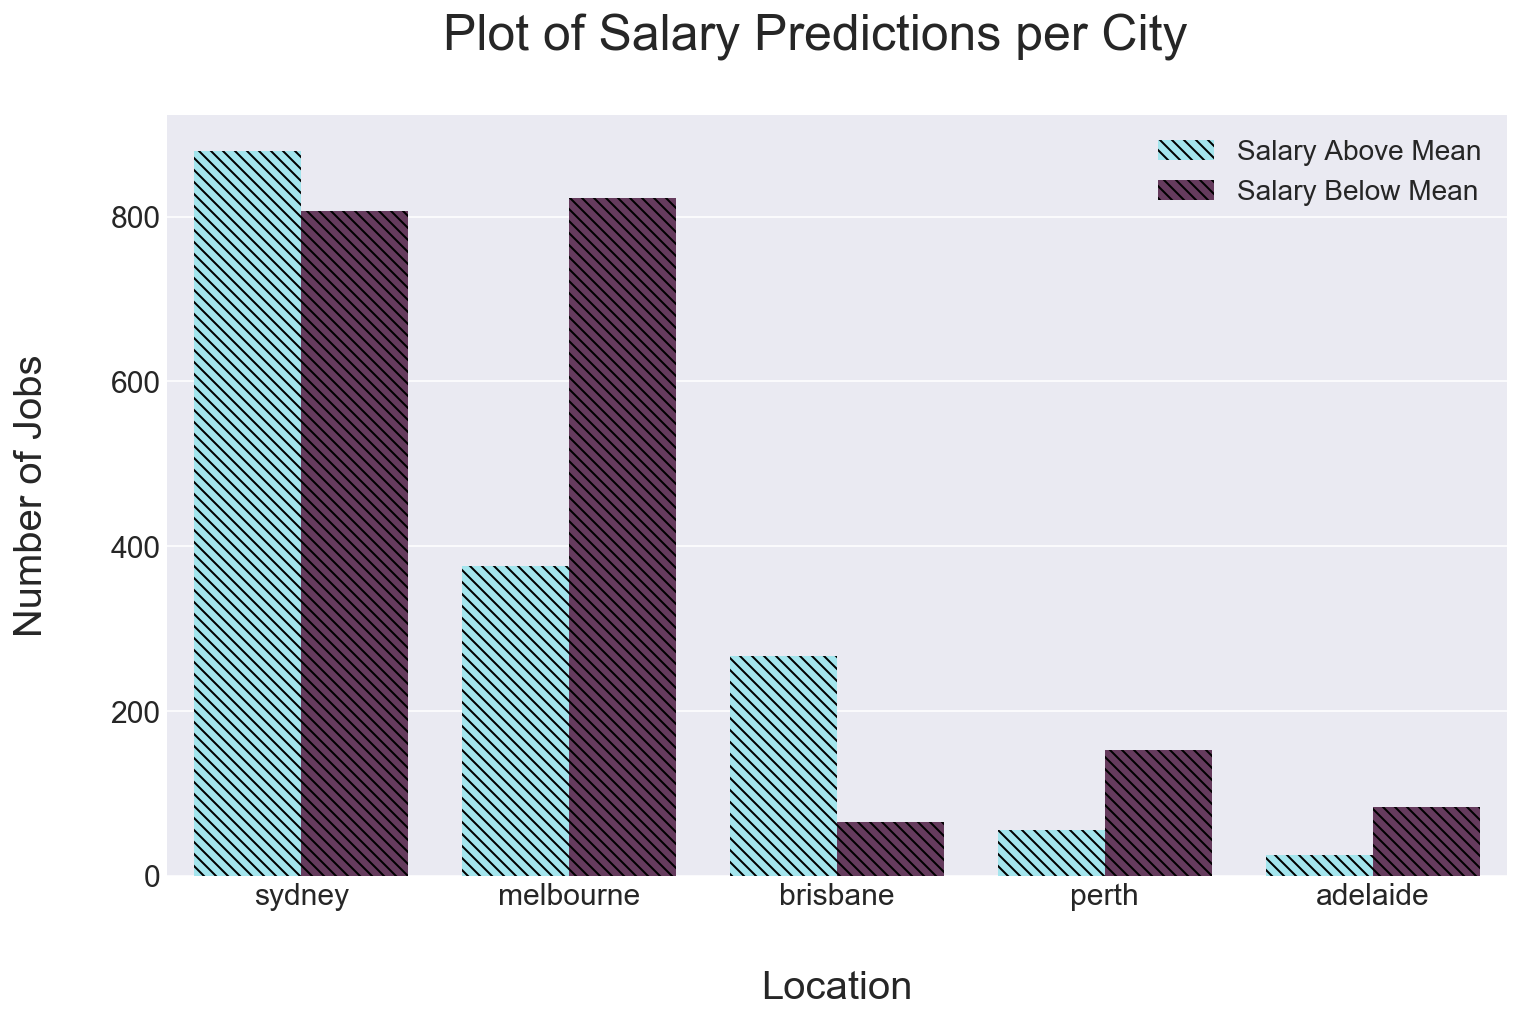

In [83]:
# Plot salary predictions per city.
sns.set_style('darkgrid')           
city_predictions = pd.DataFrame(null_salary[["location", "sal_above_mean"]])
city_predictions['sal_above_mean'] = city_predictions.sal_above_mean.map({0:"below_mean", 1:"above_mean"})

fig = plt.figure(1, figsize=(12,7))
ax = sns.countplot(x="location", hue="sal_above_mean", data=city_predictions, palette = ['#98eff9', '#6c3461'],
                  hatch ='\\\\\\\\')
plt.ylabel('Number of Jobs', fontsize=20,  labelpad=30)
plt.xlabel('Location', fontsize=20, labelpad=30)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15, rotation=0)
plt.legend(loc=1, prop={'size': 14}, labels=['Salary Above Mean','Salary Below Mean'])
plt.suptitle('Plot of Salary Predictions per City', fontsize=25)
plt.show()

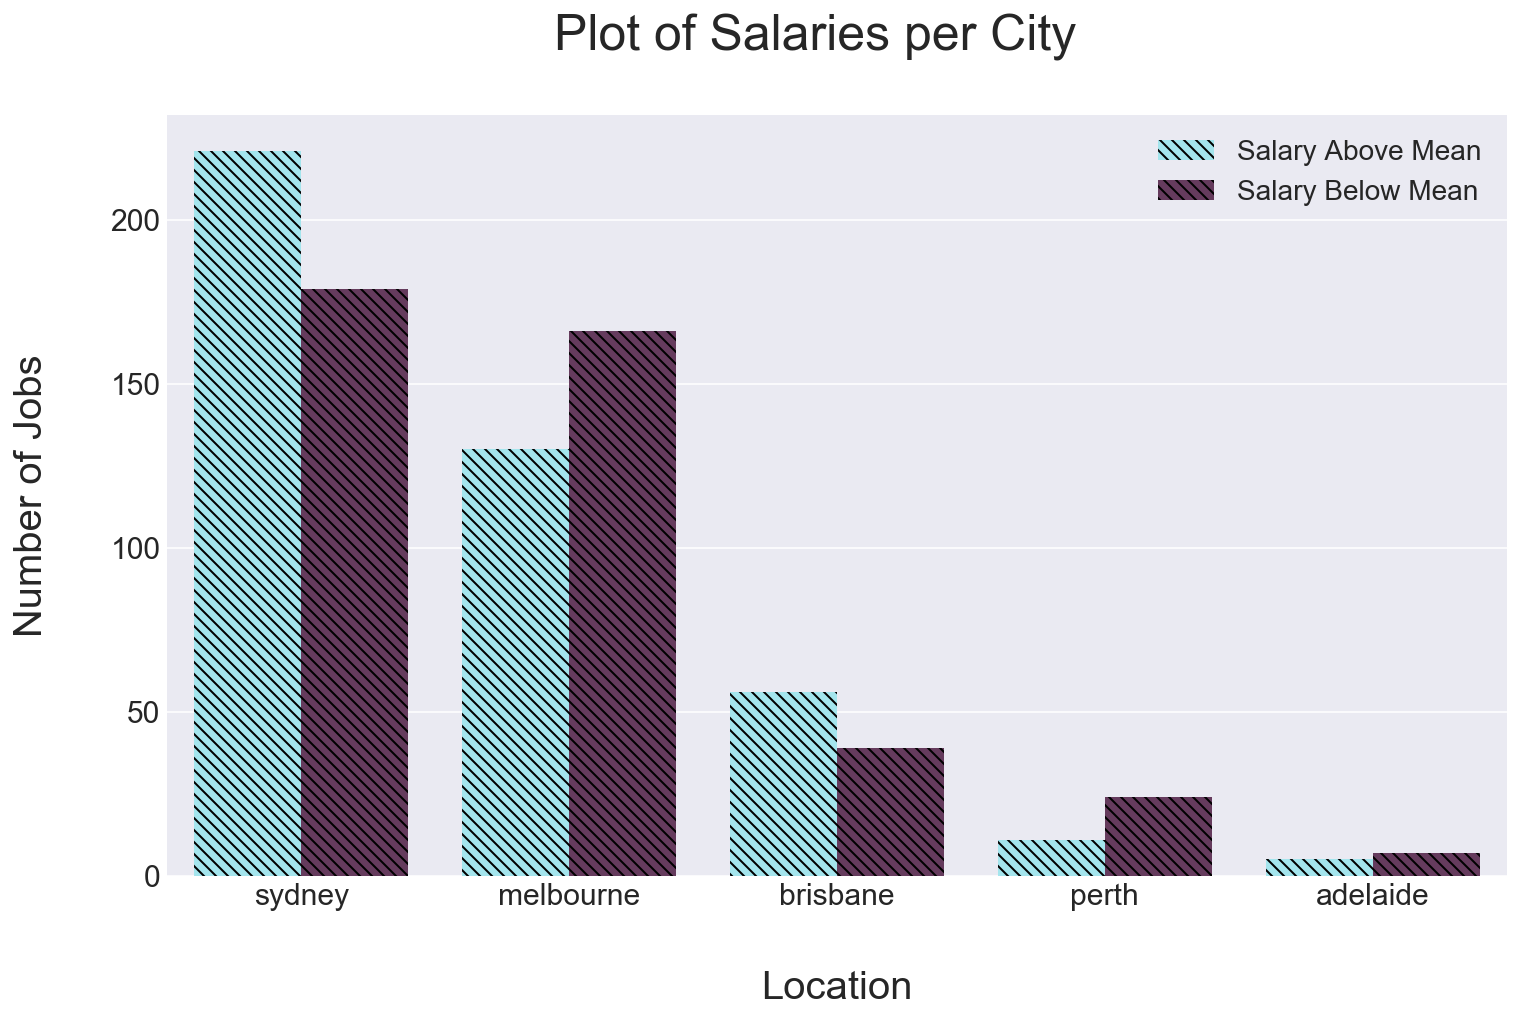

In [84]:
# Plot actual salaries per city.
city_sals = df[df.salary.notnull()]
city_sals = city_sals[["location", "sal_above_mean"]]
city_sals['sal_above_mean'] = city_sals.sal_above_mean.map({0:"below_mean", 1:"above_mean"})

fig = plt.figure(1, figsize=(12,7))
ax = sns.countplot(x="location", hue="sal_above_mean", data=city_sals, palette = ['#98eff9', '#6c3461'],
                  hatch ='\\\\\\\\')
plt.ylabel('Number of Jobs', fontsize=20,  labelpad=30)
plt.xlabel('Location', fontsize=20, labelpad=30)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15, rotation=0)
plt.legend(loc=1, prop={'size': 14}, labels=['Salary Above Mean','Salary Below Mean'])
plt.suptitle('Plot of Salaries per City', fontsize=25)
plt.show()

---
Comparing the proportions of high and low salary jobs per city for the predictions and the jobs that actually have salaries shows that the results are fairly similar. Apart from Brisbane, the model has predicted slightly higher proportion of below mean jobs for each city. As previously discussed, this is a desired outcome of the model producing more false negatives than false positives.

---

### Concatonation

---
Now I can concatonate the salary data with the non-salary data that now has the high vs low salary predictions.

---

In [85]:
salary = df[df.salary.notnull()]
all_salary = pd.concat([salary, null_salary], axis=0)    # Concatonate dataframes.

In [86]:
all_salary.drop(['salary', 'salary_type'], axis=1, inplace=True)

---
I have dropped salary and salary_type because I will no longer be using them. Instead I will me using my metric of high vs low salary. I now a value of this for all jobs that I scraped.

---

In [87]:
all_salary.head()

,location,title,company,summary,description,sal_above_mean
0,sydney,data scientist python r,correlate resources,work within a team of industry leading data sc...,our client is an industry pioneering customer ...,1.0
1,sydney,data scientists x 2,alloc8 recruitment solutions pty ltd,the need for 2 data scientist is paramount and...,the company alloc8 have been fortunate enoug...,1.0
2,sydney,data analyst perm role sydney,infopeople,i am looking for a data analyst with at least ...,i am looking for a data analyst with at least ...,0.0
3,sydney,senior data scientist leadership position,morgan mckinley,the time has come to step up and be counted as...,calling all senior data scientists the ti...,1.0
4,sydney,junior data scientist,correlate resources,as a junior data scientist the responsibilitie...,our client is an industry pioneering customer ...,0.0


In [88]:
all_salary.tail()

,location,title,company,summary,description,sal_above_mean
4367,adelaide,sales agronomist regional,farmers edge,from seed selection to yield data analytics f...,farmers edge is a global leader in decision ag...,0.0
4368,adelaide,animation supervisor,rising sun pictures rsp,please review our privacy policy for informati...,reporting directly to cg and vfx supervisors ...,0.0
4369,adelaide,vfx supervisor,rising sun pictures rsp,please review our privacy policy for informati...,the vfx supervisor is required to supervise m...,0.0
4370,adelaide,management accountant,egm partners,work collaboratively with the financial accoun...,we are resruiting a senior management accounta...,0.0
4371,adelaide,cg supervisor,rising sun pictures rsp,please review our privacy policy for informati...,the cg supervisor will supervise monitor dir...,0.0


In [89]:
all_salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4371
Data columns (total 6 columns):
location          4372 non-null object
title             4372 non-null object
company           4372 non-null object
summary           4372 non-null object
description       4372 non-null object
sal_above_mean    4372 non-null float64
dtypes: float64(1), object(5)
memory usage: 239.1+ KB


/Applications/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


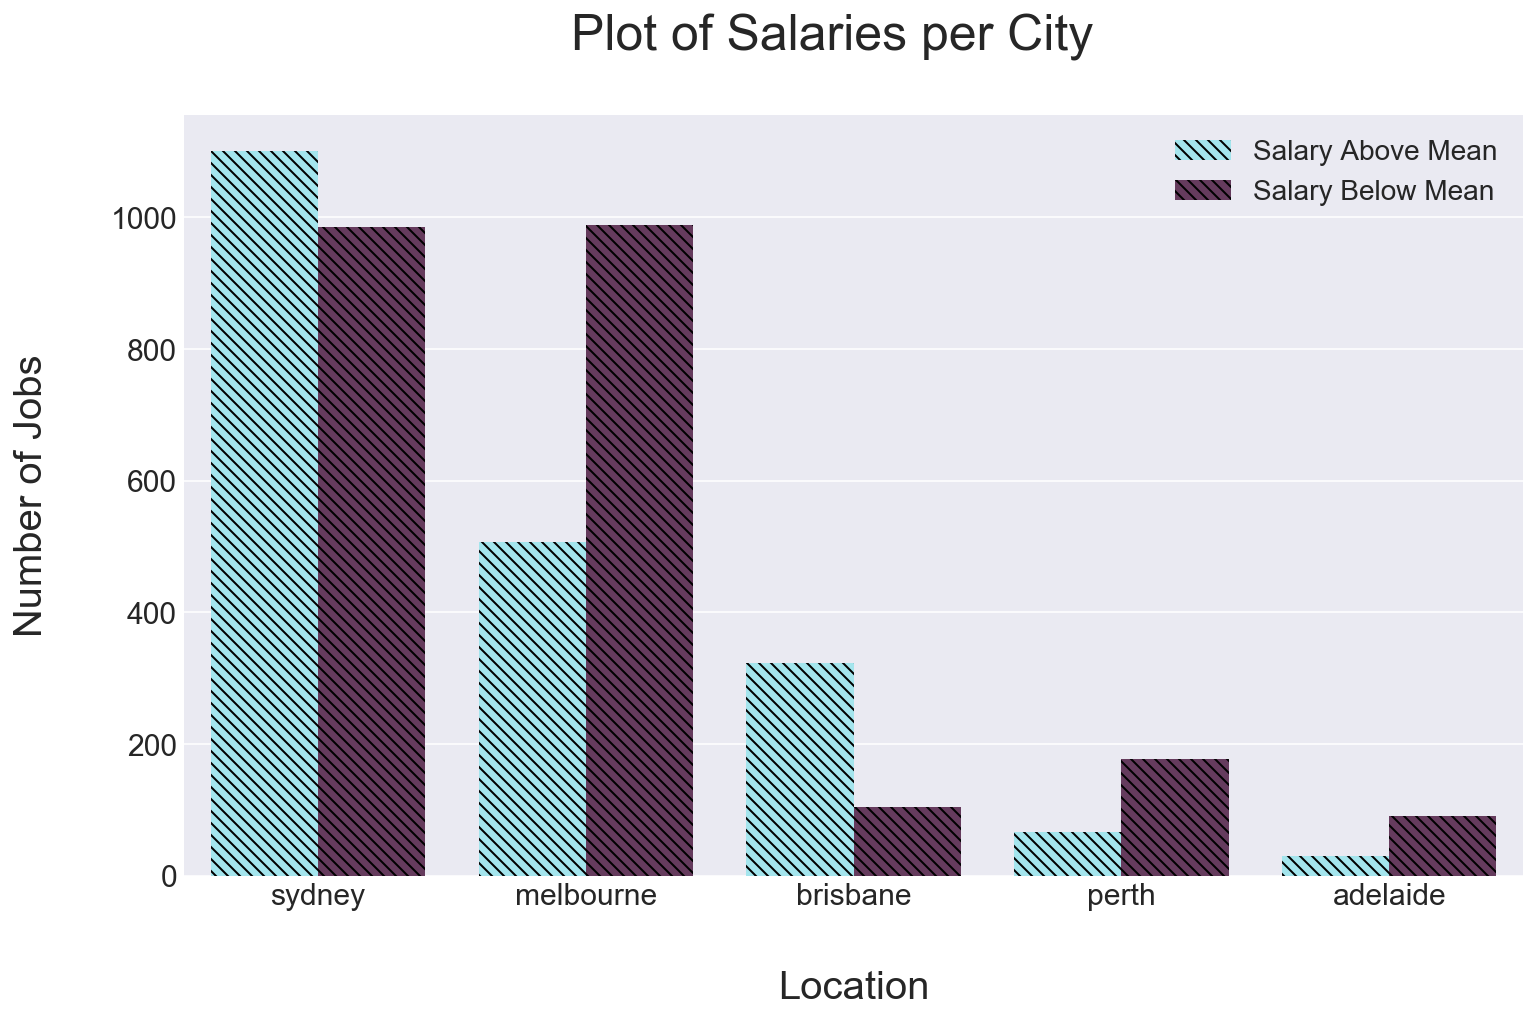

In [90]:
# Plot all salaries per city (actual and predicted).
all_city_sals = all_salary[["location", "sal_above_mean"]]
all_city_sals['sal_above_mean'] = all_city_sals.sal_above_mean.map({0:"below_mean", 1:"above_mean"})

fig = plt.figure(1, figsize=(12,7))
ax = sns.countplot(x="location", hue="sal_above_mean", data=all_city_sals, palette = ['#98eff9', '#6c3461'],
                  hatch ='\\\\\\\\')
plt.ylabel('Number of Jobs', fontsize=20,  labelpad=30)
plt.xlabel('Location', fontsize=20, labelpad=30)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15, rotation=0)
plt.legend(loc=1, prop={'size': 14}, labels=['Salary Above Mean','Salary Below Mean'])
plt.suptitle('Plot of Salaries per City', fontsize=25)
plt.show()

---
This plot shows the proportion of high and low salaries for all job listings that I scraped and includes jobs with actual salaries and jobs with predicted salaries.

---

Part 1 is now complete. I will save the predicted salary data in csv file to be used for part 2. The model for part 2 will try to predict if a job listing will be a data scienctist job or a business analyst job.

---

In [91]:
all_salary.to_csv('all_salary.csv', index=False)

[End of Modelling Part 1 (3). See file(4) for Modelling Part 2.]